# Предсказание стоимости подержанного автомобиля

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Цель:
 - Разработать модель предсказания стоимости автомобиля на вторичном рынке.
 
Метрикой качества модели в данной задаче будет MAPE(Mean Absolute Percentage Error)

In [1]:
import pandas as pd
from os.path import join
from pathlib import Path
import os
from vininfo import Vin
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

## Загрузка данных и первичное знакомство

In [2]:
dp = Path("C:/Users/79099/Desktop/Workshop_kaggle")

In [3]:
df_train = pd.read_csv(join(dp, 'train.csv'))

In [4]:
df_train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB


У нас имеется выборка из 15 колонок и 440236 строк.


Описание данных:
- year: Год выпуска автомобиля.
- make: Марка автомобиля.
- model: издание автомобиля определенной марки.
- trim: Уровни отделки салона автомобиля — это просто разные версии модели.
- body: Тип кузова транспортного средства относится к форме и модели конкретной марки автомобиля.
- transmission: механизм, который передает мощность от двигателя к колесам.
- vin: идентификационный номер транспортного средства.
- state: состояние, в котором автомобиль выставлен на аукцион.
- condition: Состояние автомобилей на момент аукциона.
- odometer: расстояние, пройденное автомобилем с момента выпуска.
- color: Цвет кузова автомобиля.
- interior: Цвет салона автомобиля.
- seller: Продавец автомобиля, автосалоны.
- sellingprice: цена, по которой автомобиль был продан на аукционе.
- saledate: Дата продажи автомобиля.


In [6]:
df_test = pd.read_csv(join(dp, 'test.csv'))

In [7]:
df_test.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110058 non-null  int64  
 1   make          107997 non-null  object 
 2   model         107979 non-null  object 
 3   trim          107944 non-null  object 
 4   body          107464 non-null  object 
 5   transmission  97047 non-null   object 
 6   vin           110058 non-null  object 
 7   state         110058 non-null  object 
 8   condition     107679 non-null  float64
 9   odometer      110039 non-null  float64
 10  color         109900 non-null  object 
 11  interior      109900 non-null  object 
 12  seller        110058 non-null  object 
 13  saledate      110058 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB


Просмотрели тестовые данные, как мы видим в них отсутствует цена продажи, попробуем в будущем дополнить этот показатель.

**Вывод**

- Данные загрузились
- Отсутствует цена продажи в тестовых данных
- В данных имеются пропуски



## Предобработка данных и статистический анализ.

### Работа с пропусками и дубликатами

In [9]:
df_train.duplicated().sum()

0

Явные дубликаты не обнаружены

In [10]:
df_train.isna().sum()

year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

- Заполним пропуски по изготовителю с помощью библиотек VIN
- Добавим код wmi в качестве признака
- Проведём замену не явных дубликатов и заполнение остальных столбцов

In [11]:
def make(x):
    vin = Vin(x)
    make = vin.manufacturer
    return make

In [12]:
def wmi(x):
    vin = Vin(x)
    wmi = vin.wmi
    return wmi

In [13]:
def preprocessing(x):
    x.body = x.body.str.lower()
    x.model = x.model.str.lower()
    x.trim = x.trim.str.lower()
    x.make = x.make.str.lower()
    x.condition = x.condition.fillna(x.condition.mean())
    x.model = x.model.fillna('not_defined')
    x.trim = x.trim.fillna('unknown')
    x.body = x.body.fillna('sedan')
    x.interior = x.interior.fillna('black')
    x.color = x.color.fillna('black')
    x.transmission = x.transmission.fillna('automatic')
    x = x.dropna()
    x.body = x.body.replace('q60 coupe','coupe')
    x.body = x.body.replace('crew cab','cab')
    x.body = x.body.replace('g sedan','sedan')
    x.body = x.body.replace('regular cab','cab')
    x.body = x.body.replace('g coupe','coupe')
    x.body = x.body.replace('e-series van','van')
    x.body = x.body.replace('crewmax cab','cab')
    x.body = x.body.replace('king cab','cab')
    x.body = x.body.replace('double cab','cab')
    x.body = x.body.replace('crewmax cab','cab')
    x.body = x.body.replace('access cab','cab')
    x.body = x.body.replace('genesis coupe','coupe')
    x.body = x.body.replace('club cab','cab')
    x.body = x.body.replace('koup','coupe')
    x.body = x.body.replace('extended cab','cab')
    x.body = x.body.replace('cts coupe','coupe')
    x.body = x.body.replace('mega cab','cab')
    x.body = x.body.replace('quad cab','cab')
    x.body = x.body.replace('supercab','cab')
    x.body = x.body.replace('elantra coupe','coupe')
    x.body = x.body.replace('promaster cargo van','van')
    x.body = x.body.replace('g convertible','convertible')
    x.body = x.body.replace('beetle convertible','convertible')
    x.body = x.body.replace('q60 convertible','convertible')
    x.body = x.body.replace('xtracab','cab')
    x.body = x.body.replace('ram van','van')
    x.body = x.body.replace('cts-v wagon','wagon')
    x.body = x.body.replace('tsx sport wagon','wagon')
    x.body = x.body.replace('g37 coupe','coupe')
    x.body = x.body.replace('cts-v coupe','coupe')
    x.body = x.body.replace('regular-cab','cab')
    x.body = x.body.replace('transit van','van')
    x.body = x.body.replace('g37 convertible','convertible')
    x.body = x.body.replace('granturismo convertible','convertible')
    x.body = x.body.replace('cab plus 4','convertible')
    x.body = x.body.replace('cab plus','convertible')
    x.body = x.body.replace('cts wagon','wagon')
    x.make = x.make.replace('chrysler canada','chrysler')
    x.make = x.make.replace('chevrolet mexico','chevrolet')
    x.make = x.make.replace('ford otosan','ford')
    x.make = x.make.replace('chevrolet usa','chevrolet')
    x.make = x.make.replace('daimlerchrysler ag/daimler ag','chrysler')
    x.make = x.make.replace('mazda mexico','mazda')
    x.make = x.make.replace('chevrolet australia','chevrolet')
    x.make = x.make.replace('mercedes-benz (sprinter)','mercedes-benz')
    x.make = x.make.replace('volkswagen commercial vehicles','volkswagen')
    x.make = x.make.replace('aston martin lagonda limited','aston martin')
    x.make = x.make.replace('dodge mexico','dodge')
    x.make = x.make.replace('toyota mexico','toyota')
    x.make = x.make.replace('mitsubishi thailand','mitsubishi')
    x.make = x.make.replace('bmw m','bmw')
    x.make = x.make.replace('honda mexico','honda')
    x.make = x.make.replace('plymouth mexico','plymouth')
    x.make = x.make.replace('lexus canada','lexus')
    x.make = x.make.replace('chevrolet canada','chevrolet')
    x.make = x.make.replace('gmc truck','gmc')
    x.make = x.make.replace('daimler ag (sprinter)','mercedes-benz')
    x.make = x.make.replace('porsche car','porsche')
    x.make = x.make.replace('porsche suv','porsche')
    return x
    

In [14]:
df_train['make'] = df_train['vin'].apply(make)

In [15]:
df_train['wmi'] = df_train['vin'].apply(wmi)

In [16]:
df_train = preprocessing(df_train) 

C:\Users\79099\anaconda3\envs\ds1_practicum_env\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Проделаем те же операции для тестовой выборки

In [17]:
df_test['make'] = df_test['vin'].apply(make)

In [18]:
df_test['wmi'] = df_test['vin'].apply(wmi)

In [19]:
df_test = preprocessing(df_test) 

C:\Users\79099\anaconda3\envs\ds1_practicum_env\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Статистический анализ данных

#### Год выпуска

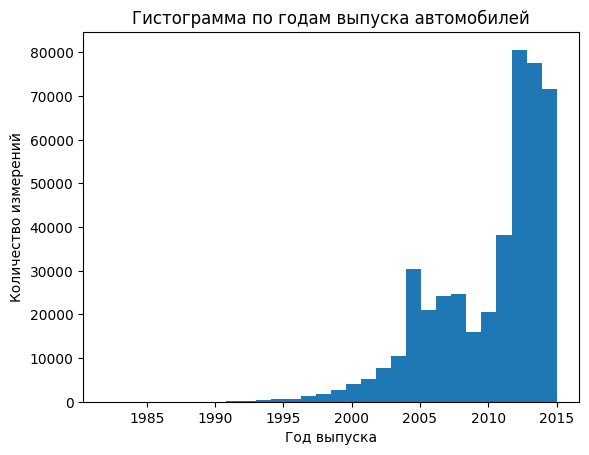

In [20]:
plt.hist(df_train['year'], bins=30)
plt.title('Гистограмма по годам выпуска автомобилей')
plt.xlabel('Год выпуска')
plt.ylabel('Количество измерений')
plt.show()

#### Пробег

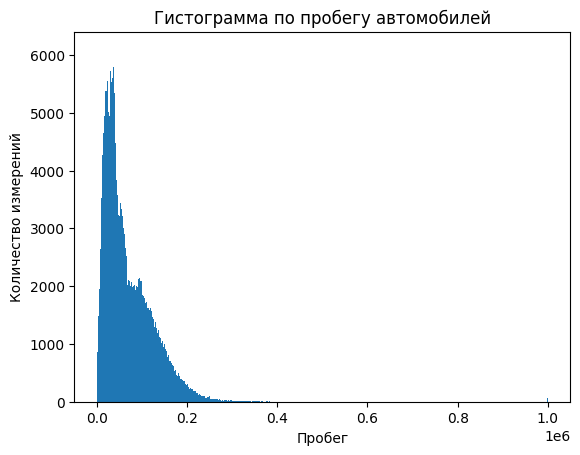

In [21]:
plt.hist(df_train['odometer'], bins=1000)
plt.title('Гистограмма по пробегу автомобилей')
plt.xlabel('Пробег')
plt.ylabel('Количество измерений')
plt.show()

Построим диаграмму размаха

<AxesSubplot:>

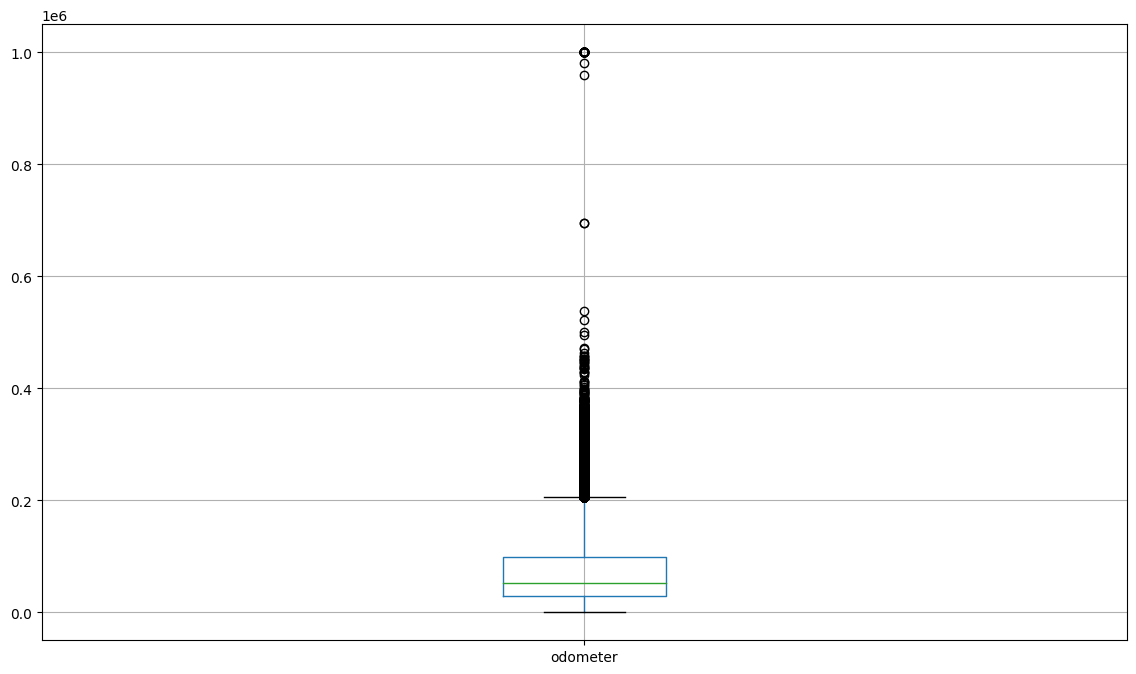

In [22]:
df_train.boxplot(column='odometer', figsize=(14,8))

In [23]:
df_train['odometer'].describe()

count    440167.000000
mean      68344.421604
std       53542.203908
min           1.000000
25%       28258.000000
50%       52098.000000
75%       99272.000000
max      999999.000000
Name: odometer, dtype: float64

In [24]:
df_train['odometer'].quantile(.005)

1197.0

In [25]:
df_train['odometer'].quantile(.995)

251443.81999999925

Отсечём пробеги меньше 1000  и больше 252000

In [26]:
def odometr(x):
    x = x.query('252000 >odometer > 1000')
    return x

In [27]:
df_train = odometr(df_train)


#### Цена

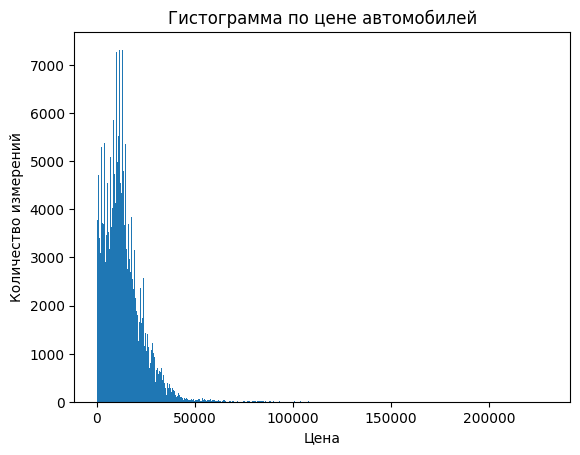

In [28]:
plt.hist(df_train['sellingprice'], bins=1000)
plt.title('Гистограмма по цене автомобилей')
plt.xlabel('Цена')
plt.ylabel('Количество измерений')
plt.show()

<AxesSubplot:>

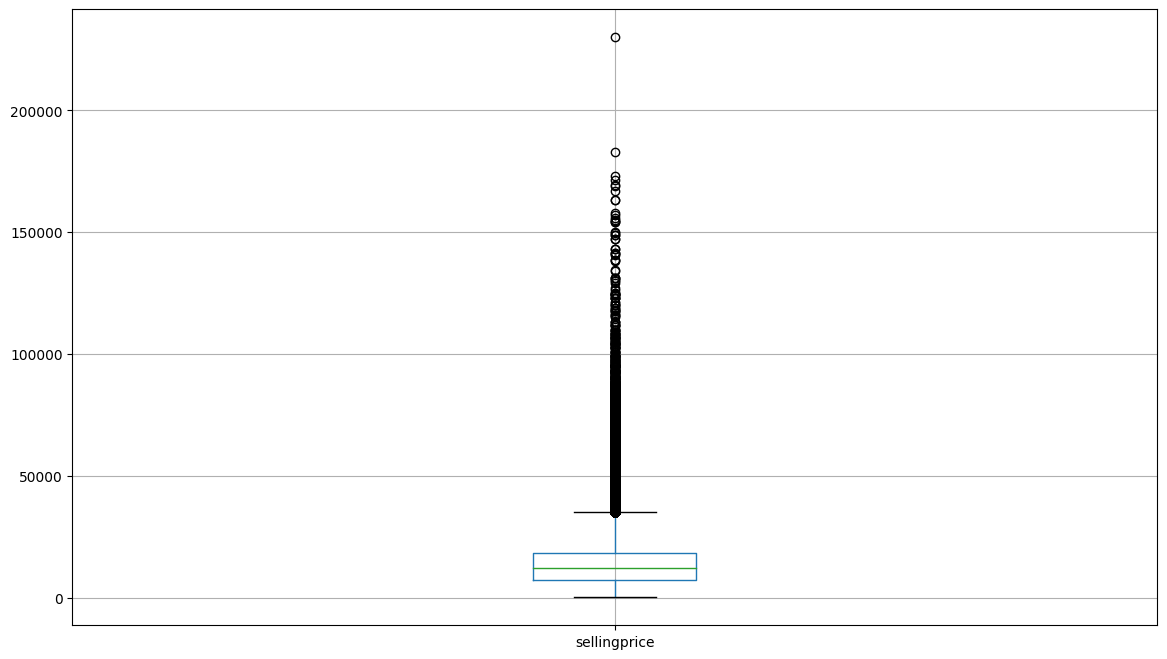

In [29]:
df_train.boxplot(column='sellingprice', figsize=(14,8))

In [30]:
df_train['sellingprice'].quantile(.005)

400.0

In [31]:
df_train['sellingprice'].quantile(.995)

52500.0

In [32]:
df_train['sellingprice'].describe()

count    435958.000000
mean      13646.365480
std        9680.816007
min         100.000000
25%        7000.000000
50%       12200.000000
75%       18200.000000
max      230000.000000
Name: sellingprice, dtype: float64

In [33]:
def price(x):
    x = x.query('52500.0 >sellingprice > 400.0')
    return x

In [34]:
df_train = price(df_train)

In [35]:
df_train['sellingprice'].describe()

count    430517.000000
mean      13471.137444
std        8763.789694
min         420.000000
25%        7100.000000
50%       12200.000000
75%       18200.000000
max       52400.000000
Name: sellingprice, dtype: float64

**Вывод**

Подготовили данные

## Добавление признаков

Добавим новые признаки:
 - Средняя цена по году для каждого производителя
 - Средняя цена по году для каждого производителя и каждой модели
 - Максимальная цена по году для каждого производителя и каждой модели
 - Минимальная цена по году для каждого производителя и каждой модели
 - Средняя цена по году для каждого производителя и каждой модели исходя из состояния

In [36]:
def mean_new_fichers(x):
    x['mean_year_make_price'] =x.groupby(['year', 'make'])['sellingprice'].transform('mean')
    x['mean_year_make_mpdel_price'] = x.groupby(['year', 'make', 'model'])['sellingprice'].transform('mean')
    x['max_year_make_mpdel_price'] = x.groupby(['year', 'make', 'model'])['sellingprice'].transform('max')
    x['min_year_make_mpdel_price'] = x.groupby(['year', 'make', 'model'])['sellingprice'].transform('min')
    x['min_year_make_mpdel_condition_price'] = x.groupby(['year', 'make', 'model', 'condition'])['sellingprice'].transform('mean')
    
    return x

In [37]:
df_train = mean_new_fichers(df_train)

In [38]:
df_train.head(5)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,interior,seller,sellingprice,saledate,wmi,mean_year_make_price,mean_year_make_mpdel_price,max_year_make_mpdel_price,min_year_make_mpdel_price,min_year_make_mpdel_condition_price
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT),2FM,15255.963074,16823.317308,24900,6000,17059.210526
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST),3FA,19580.324111,15664.307497,49000,2400,14531.521739
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT),3N1,14760.784061,9765.381443,20700,900,8200.000000
3,2003,hummer,h2,base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),5GR,13434.745763,13483.620690,24600,7300,13140.000000
4,2007,ford,fusion,sel,sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,...,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST),3FA,7136.153998,3969.761905,8500,700,3164.285714


## Построение модели

Лучшие результаты показала модель catBoost

In [39]:
features_train_cat = df_train.drop(['vin', 'saledate', 'sellingprice'], axis=1)

In [40]:
target_train_cat = df_train['sellingprice'] 

In [41]:
catBoost = CatBoostRegressor(loss_function='MAE', eval_metric = 'MAE', random_state=1234)

In [42]:
cat_features_final = ['make', 'model', 'trim', 'body', 'transmission',  
                'state', 'color', 'interior', 'seller', 'wmi']

In [43]:
param_search_1 = [{'depth' : range (4, 5),
                'learning_rate' : [0.2],
                'iterations' : range(31, 91, 30),
                'verbose' : [False]
               }]

In [44]:
cat = GridSearchCV(estimator=catBoost,
                  cv=5,
                  param_grid=param_search_1,
                  scoring = 'neg_mean_absolute_percentage_error')
cat.fit(features_train_cat, target_train_cat, cat_features=cat_features_final)
print('Оптимальные параметры: ', cat.best_params_)
print(f'MAPE модели CatBoost по кросс-валидации равно {-1*cat.best_score_}')

Оптимальные параметры:  {'depth': 4, 'iterations': 61, 'learning_rate': 0.2, 'verbose': False}
MAPE модели CatBoost по кросс-валидации равно 0.14372025828288532


## Вывод

Получили модель, которая выдаёт значения MAPE на кросс-валидации 0.1437

Я не уверен в правильности выбранного мной подхода, потому что я создал новые признаки: среднюю цену по годам 
и производителям, исходя из продажной цены. Но в реальной жизни при определении стоимости автомобиля у нас цены не будет
и по хорошему надо "новые" столбцы в тестовых данных заполнить соответствующими значениями из тренировочных данных.
То есть: средняя стоимость продажи например автомобиля форд 2009 года в тестовых данных должна братся из соответствующего значения в тренировочных данных, но не факт что для того автомобиля, который мы возьмём такие данные будут в тренировочных данных и к тому же я не нашел, как это сделать технически. Буду благодарен за подсказку.
